In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import pi

from functorch import vmap
from matplotlib.colors import CenteredNorm
import matplotlib.pyplot as plt
import torch

from caustic.cosmology import FlatLambdaCDMCosmology
from caustic.fwd_raytrace import fwd_raytrace
from caustic.lenses import SIE, Point
from caustic.lenses import get_pix_magnification, get_pix_jacobian, get_magnification
from caustic.sources import Sersic
from caustic.utils import get_meshgrid

Setup

In [3]:
s = torch.tensor(1e-10)

fov = 5.0
n_pix = 100
res = fov / n_pix
thx, thy = get_meshgrid(res, n_pix, n_pix)

cosmology = FlatLambdaCDMCosmology("cosmo")
z_l = torch.tensor(0.8)
lens = SIE("sie", cosmology, z_l, s=s)

z_s = torch.tensor(1.9)
src = Sersic("sersic", s=s)

print(lens)
print(src)

x_lens = torch.tensor([0.12, -0.03, 0.7, pi / 3, 1.2])
x_src = torch.tensor([0.0, 0.0, 0.8, 0.5, 1.5, 0.1, 1.0])

SIE(
    name='sie',
    static=[z_l, s],
    dynamic=[thx0, thy0, q, phi, b; ('cosmo': ['h0', 'rho_cr_0', 'Om0'])]
)
Sersic(
    name='sersic',
    static=[s],
    dynamic=[thx0, thy0, q, phi, index, th_e, I_e]
)


Extended arc

In [4]:
bx, by = lens.raytrace(thx, thy, z_s, lens.x_to_dict(x_lens))
mu = src.brightness(bx, by, src.x_to_dict(x_src))

Find quasar images

In [5]:
thxs, thys = fwd_raytrace(
    x_src[0],
    x_src[1],
    lambda thx, thy: torch.stack(lens.raytrace(thx, thy, z_s, lens.x_to_dict(x_lens))),
    4,
    (-fov / 2, fov / 2),
    (-fov / 2, fov / 2),
    n_guesses=50,
).t()

Text(0, 0.5, "$y$ [$''$]")

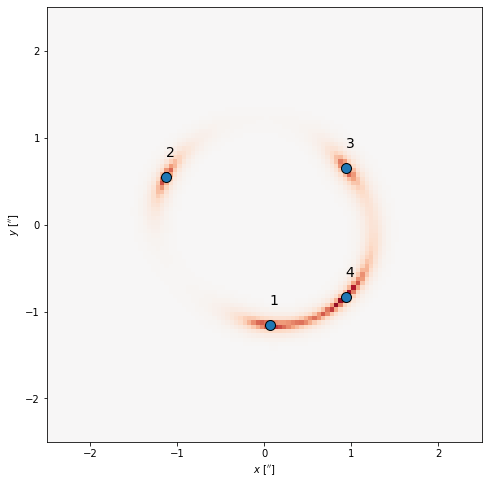

In [6]:
plt.figure(figsize=(8, 8))

plt.imshow(
    mu,
    cmap="RdBu_r",
    origin="lower",
    norm=CenteredNorm(),
    extent=(-fov / 2, fov / 2, -fov / 2, fov / 2),
)
for idx in range(4):
    plt.scatter(thxs[idx], thys[idx], c="C0", ec="k", s=100)
    plt.annotate(
        f"{idx + 1}",
        (thxs[idx], thys[idx]),
        (0, 20),
        textcoords="offset points",
        fontsize=14,
    )

plt.xlabel(r"$x$ [$''$]")
plt.ylabel(r"$y$ [$''$]")

In [9]:
def get_parallelogram_sampler(thx, thy, bx, by, fov_src, lens, x):
    """
    Gets a function to generate samples in a parallelogram that trace back to
    a square region in the source plane.
    
    Args:
        thx, thy: image-plane coordinates.
        bx, by: source-plane coordinates that solve the lensing equation.
        fov_src: width of source region.
        lens: lens instance.
        x: params for lens.
    """
    thxy_corners_im = torch.stack((thx, thy))

    # We'll assume the source region maps to a parallelogram in the lens plane,
    # so we can drop the last corner
    corners_src = torch.stack(
        (
            (bx + torch.tensor((-fov_src / 2, fov_src / 2))).repeat(2),
            (by + torch.tensor((-fov_src / 2, fov_src / 2))).repeat_interleave(2),
        )
    )[..., :-1]

    # Since source region is small, we can linearize the lensing equation to
    # map into the lens plane
    jac = torch.stack(
        [
            torch.stack((j0, j1))
            for j0, j1 in get_pix_jacobian(
                lens.raytrace, thx, thy, z_s, x
            )
        ]
    )
    corners_im = torch.linalg.inv(jac) @ corners_src + thxy_corners_im[:, None]

    # Vectors defining sides of parallelogram
    side_a = corners_im[:, 1] - corners_im[:, 0]
    side_b = corners_im[:, 2] - corners_im[:, 0]

    def sampler(n=1):
        # See https://stackoverflow.com/a/240790
        u = torch.rand(n, 1) - 0.5
        v = torch.rand(n, 1) - 0.5
        return thxy_corners_im + u * side_a[None] + v * side_b[None]
    
    return sampler

In [16]:
# Set up sampler for an image
idx = 0
fov_src = res / 10_000
sampler = get_parallelogram_sampler(
    thxs[idx], thys[idx], x_src[0], x_src[1], fov_src, lens, lens.x_to_dict(x_lens)
)

# Sample star parameters -- these are fixed across time
n_pts = 30
thx_pts, thy_pts = sampler(n_pts).t()
th_ein_pts = torch.tensor(1e-6).repeat(n_pts)
vx_pts = 1e-5 * torch.randn(n_pts)
vy_pts = 1e-5 * torch.randn(n_pts)

In [17]:
def alpha_snapshot(thx, thy, t, thx_pts, thy_pts, vx_pts, vy_pts, th_ein_pts):
    x_pts = torch.stack((thx_pts + vx_pts * t, thy_pts + vy_pts * t, th_ein_pts), -1)
    ax, ay = torch.stack(
        lens.alpha(thx, thy, z_s, lens.x_to_dict(x_lens))
    ) + torch.stack(
        vmap(pt.alpha, (None, None, None, 0))(thx, thy, z_s, pt.x_to_dict(x_pts))
    ).sum(
        -2
    )
    return ax, ay

In [18]:
pt = Point("pt", cosmology, z_l)

In [19]:
# Ray-trace through a bunch of random points over a bunch of times
ts = torch.linspace(0, 5, 10)
n_mc = 300_000
thx_mc, thy_mc = sampler(n_mc).t()

ax_ts, ay_ts = vmap(
    alpha_snapshot,
    (None, None, 0, None, None, None, None, None),
)(thx_mc, thy_mc, ts, thx_pts, thy_pts, vx_pts, vy_pts, th_ein_pts)
bx_ts = thx_mc - ax_ts
by_ts = thy_mc - ay_ts

Text(0.5, 1.0, 'Image 1, t=0.0')

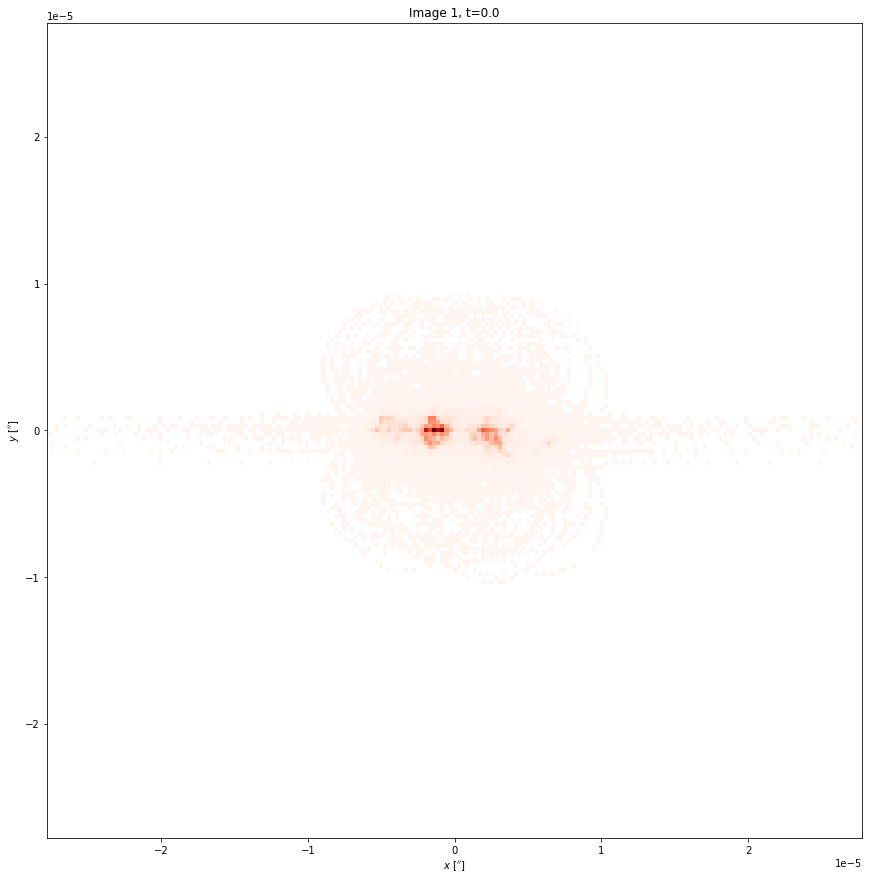

In [20]:
i = 0

# Plot
plt.figure(figsize=(15, 15))

extent_x = (x_src[0] - 10*fov_src/1.8, x_src[0] + 10*fov_src/1.8)
extent_y = (x_src[1] - 10*fov_src/1.8, x_src[1] + 10*fov_src/1.8)

plt.hist2d(
    bx_ts[i].numpy(),
    by_ts[i].numpy(),
    bins=(torch.linspace(*extent_x, 200), torch.linspace(*extent_y, 200)),
#     bins = 100,
    cmap="Reds",
    cmin=1,
)

plt.gca().set_aspect("equal")
# plt.xlim(extent_x)
# plt.ylim(extent_y)
plt.xlabel(r"$x$ [$''$]")
plt.ylabel(r"$y$ [$''$]")
plt.title(f"Image {idx + 1}, t={ts[i]}")